# Project Text Mining (Part 1) 

This notebook was made as the Text Mining Project for Master Data Mining of Université Lyon 2. 

## Objective:

The main goal is to pratice the concepts seen in class and apply text mining tecniques in a dataset. 

## Plan:

This notebook will be separated into the following sections

$\rightarrow$ Acquisition des données 

$\rightarrow$. Exercice 2 : Construction d’un index sur les mots

$\rightarrow$. Exercice 3 : Mise en place d’un moteur de recherche


**Owners**: Lia Furtado and Hugo Vinision 


---

In [4]:
import json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk 
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
import unicodedata
from collections import Counter
import spacy
import string
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import math
nlp = spacy.load("en_core_web_sm")

---
## Acquisition des données

This part consists in loading the dataset from https://www.aminer.org/citation and creating a usable dataset with smaller size and better structure. 



In [6]:
#Loading the json dataset retrieved from the website 
data = []
with open('dblp-ref/dblp-ref-0.json') as f:
    for line in f:
        data.append(json.loads(line))
        
df = pd.json_normalize(data)

#Get a small subset of data by filtering only the citations from 2016

data_2016 = df[(df['year'] == 2016)]

#Remove movies with abstract null
data_2016 = data_2016[~data_2016['abstract'].isnull()] 
#Reindex the dataframe
data_2016.reset_index(drop=True, inplace=True)

In [16]:
data_2016.head()

,abstract,authors,n_citation,references,title,venue,year,id
0,"In this article, we show how to compute the wi...","[Alexandr Andoni, Huy L. Nguyêݱn]",0,"[04d59cae-87b1-4706-9f5f-009ee3e94626, 228e075...",Width of Points in the Streaming Model,symposium on discrete algorithms,2016,2a68616f-ae27-46aa-8d7b-292a23e3291f
1,Traditional methods on video summarization are...,"[Linbo Wang, Xianyong Fang, Yanwen Guo, Yanwei...",3,"[0f80ec27-572e-473b-a403-f0f7c47c4743, 18a8568...",Multi-view Metric Learning for Multi-view Vide...,cyberworlds,2016,348045c5-4d43-4c96-b106-e1038e5d4aaa
2,Decision tree is an important method for both ...,"[Singh Vijendra, Hem Jyotsana Parashar, Nisha ...",0,"[6d903194-6be4-4780-9ccf-d60916e00770, 7396789...",A New Method for Classification of Datasets fo...,arXiv: Learning,2016,82f3e31c-2139-42f9-88ab-2116621eb207
3,Full-reference image quality assessment (FR-IQ...,"[Ashirbani Saha, Q. M. Jonathan Wu]",50,"[02acc8f4-e6d9-4958-bd08-a1185631f22a, 108636d...",Full-reference image quality assessment by com...,Signal Processing,2016,0db3464c-7e35-4bb1-be09-f6f079258e0f
4,The Fomin-Kirillov algebra E n is a noncommuta...,[Ricky Ini Liu],1,"[7ff3b6e7-35b3-4cca-af97-c39d38bdf080, d885dd2...",On the commutative quotient of Fomin-Kirillov ...,European Journal of Combinatorics,2016,221a3099-ae5a-4e38-b793-d27d1795313f


In [17]:
# save to csv
data_2016.to_csv('dblp_2016.csv', index=False)

---
## Construction d’un index sur les mots


This section is to first preprocess the texts by removing stop-words, frequent words, rare words, perform stemming or lemmatization etc. Then to vizualize some common words and understand the data. Finally, to vectorize the words by performing Count Vectorizer or TF-IDF transformation. This two methods are explained more bellow:

$\rightarrow$ **Count Vectorizer**
```
Turn the sentences into a sparse matrix by setting to 1 when a word exists in the sentence and 0 otherwise. The image bellow represents how this happens. Is a tecnique that counts the amount of times a word appears in a corpus (set of texts). 
```
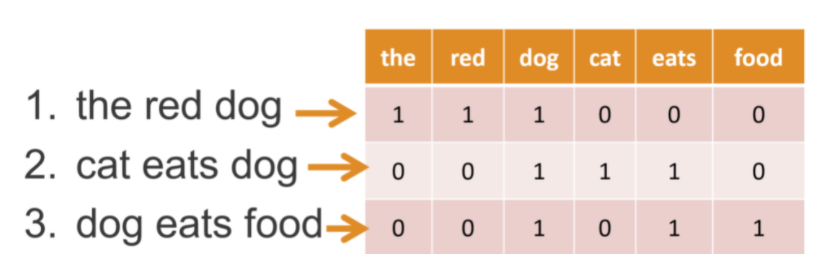

$\rightarrow$ **Term Frequency Inverse Document Frequency Vectorizer**
```
This vectorizer considers in the overall documents the weight of words.

Tfidf is equals to number of word appears in a document times the inverse document frequency of the word across the set of 
documents  
```

**Text Cleaning and Pre-processing**

In [18]:
data = pd.read_csv('dblp_2016.csv')  

In [19]:
data.head()

,abstract,authors,n_citation,references,title,venue,year,id
0,"In this article, we show how to compute the wi...","['Alexandr Andoni', 'Huy L. Nguyêݱn']",0,"['04d59cae-87b1-4706-9f5f-009ee3e94626', '228e...",Width of Points in the Streaming Model,symposium on discrete algorithms,2016,2a68616f-ae27-46aa-8d7b-292a23e3291f
1,Traditional methods on video summarization are...,"['Linbo Wang', 'Xianyong Fang', 'Yanwen Guo', ...",3,"['0f80ec27-572e-473b-a403-f0f7c47c4743', '18a8...",Multi-view Metric Learning for Multi-view Vide...,cyberworlds,2016,348045c5-4d43-4c96-b106-e1038e5d4aaa
2,Decision tree is an important method for both ...,"['Singh Vijendra', 'Hem Jyotsana Parashar', 'N...",0,"['6d903194-6be4-4780-9ccf-d60916e00770', '7396...",A New Method for Classification of Datasets fo...,arXiv: Learning,2016,82f3e31c-2139-42f9-88ab-2116621eb207
3,Full-reference image quality assessment (FR-IQ...,"['Ashirbani Saha', 'Q. M. Jonathan Wu']",50,"['02acc8f4-e6d9-4958-bd08-a1185631f22a', '1086...",Full-reference image quality assessment by com...,Signal Processing,2016,0db3464c-7e35-4bb1-be09-f6f079258e0f
4,The Fomin-Kirillov algebra E n is a noncommuta...,['Ricky Ini Liu'],1,"['7ff3b6e7-35b3-4cca-af97-c39d38bdf080', 'd885...",On the commutative quotient of Fomin-Kirillov ...,European Journal of Combinatorics,2016,221a3099-ae5a-4e38-b793-d27d1795313f


In [10]:
#Joining the title and abstract text
data['text'] = data['title'] + ' ' + data['abstract']

In [11]:
#Loading the stopwords
stop_words = stopwords.words('english')
stopwords_en = set(stop_words)


In [12]:
def cleanup_text(msg):
    #removing pontuation
    No_Punctuation = [char if char not in string.punctuation else ' ' for char in msg ]
    sentence = ''.join(No_Punctuation)
    #remove all non latin caracters
    sentence = re.sub(r'[^\x00-\x7f]',r'', sentence)
    #removing digits
    sentence = re.sub("\S*\d+\S*", "", sentence)
    #remove diactric accents and greek letters
    sentence = ''.join(c for c in unicodedata.normalize('NFD', sentence)
                  if unicodedata.category(c) != 'Mn')
    #### Word tokenization is the process of splitting up “sentences” into “words”
    sentence = nltk.word_tokenize(sentence)
    #Stemming the words
    #stemmer = PorterStemmer()
    return " ".join(word.lower() for word in sentence if word.lower() not in stopwords_en and len(word.lower())>1)


In [13]:
#Most 40 used words in bag of words
def clean_words(msg):
    erase_words = ['based','data', 'proposed', 'paper', 'model','method','results','time','algorithm','using','problem', \
                   'two', 'system','performance','approach','network','show','also','information','analysis','new', \
                   'used','systems', 'different','study','methods','networks','number','one','order','set','algorithms',\
                   'high','control','models','propose','learning','use','image','problems']
    
    return " ".join(char for char in word_tokenize(msg) if char not in erase_words)

In [11]:
data['text_clean'] = data['text'].apply(lambda x:cleanup_text(x))
data['text_clean'] = data['text_clean'].apply(lambda x:clean_words(x))

In [12]:
data.head()

,abstract,authors,n_citation,references,title,venue,year,id,text,text_clean
0,"In this article, we show how to compute the wi...","['Alexandr Andoni', 'Huy L. Nguyêݱn']",0,"['04d59cae-87b1-4706-9f5f-009ee3e94626', '228e...",Width of Points in the Streaming Model,symposium on discrete algorithms,2016,2a68616f-ae27-46aa-8d7b-292a23e3291f,Width of Points in the Streaming Model In this...,width points streaming article compute width d...
1,Traditional methods on video summarization are...,"['Linbo Wang', 'Xianyong Fang', 'Yanwen Guo', ...",3,"['0f80ec27-572e-473b-a403-f0f7c47c4743', '18a8...",Multi-view Metric Learning for Multi-view Vide...,cyberworlds,2016,348045c5-4d43-4c96-b106-e1038e5d4aaa,Multi-view Metric Learning for Multi-view Vide...,multi view metric multi view video summarizati...
2,Decision tree is an important method for both ...,"['Singh Vijendra', 'Hem Jyotsana Parashar', 'N...",0,"['6d903194-6be4-4780-9ccf-d60916e00770', '7396...",A New Method for Classification of Datasets fo...,arXiv: Learning,2016,82f3e31c-2139-42f9-88ab-2116621eb207,A New Method for Classification of Datasets fo...,classification datasets mining decision tree i...
3,Full-reference image quality assessment (FR-IQ...,"['Ashirbani Saha', 'Q. M. Jonathan Wu']",50,"['02acc8f4-e6d9-4958-bd08-a1185631f22a', '1086...",Full-reference image quality assessment by com...,Signal Processing,2016,0db3464c-7e35-4bb1-be09-f6f079258e0f,Full-reference image quality assessment by com...,full reference quality assessment combining gl...
4,The Fomin-Kirillov algebra E n is a noncommuta...,['Ricky Ini Liu'],1,"['7ff3b6e7-35b3-4cca-af97-c39d38bdf080', 'd885...",On the commutative quotient of Fomin-Kirillov ...,European Journal of Combinatorics,2016,221a3099-ae5a-4e38-b793-d27d1795313f,On the commutative quotient of Fomin-Kirillov ...,commutative quotient fomin kirillov algebras f...


In [13]:
data.to_csv('dblp_2016_cleaned.csv', index=False)

**Common words and vizualization** 

In [14]:
docs = [[w.lower() for w in word_tokenize(text)] 
            for text in list(data['text_clean'])]
bag_of_words = [item for sublist in docs for item in sublist]

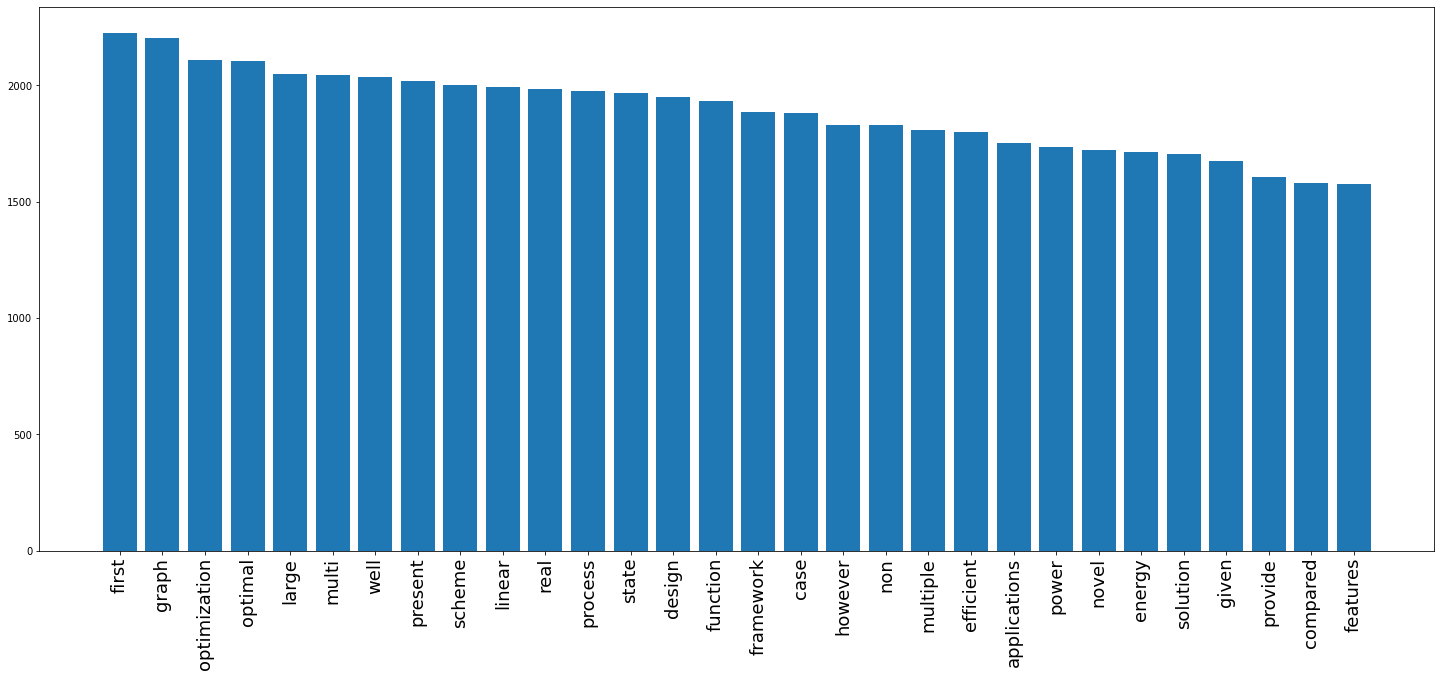

In [34]:
x=[]
y=[]
#Most common words
counter = Counter(bag_of_words)
most = counter.most_common()

for word,count in most[:30]:
        x.append(word)
        y.append(count)
plt.figure(figsize=(25,10))
plt.xticks(fontsize=18, rotation=90)

plt.bar(x,y)
plt.show()

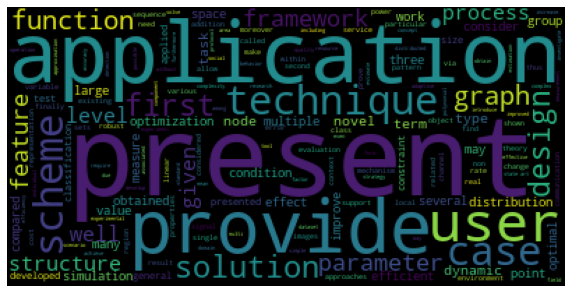

In [16]:
# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize=(10,8))
word_cloud = WordCloud(background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(bag_of_words))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()


**Vectorization** 

In [17]:
#Applying the Count Vectorizer
count_vectorizer = CountVectorizer(min_df=2)
emb = count_vectorizer.fit_transform(data['text_clean'])


In [18]:
count_vectorizer.vocabulary_

{'width': 18579,
 'points': 12685,
 'streaming': 16187,
 'article': 956,
 'compute': 3096,
 'dynamic': 5143,
 'low': 9816,
 'dimensional': 4600,
 'particular': 12142,
 'assume': 1065,
 'stream': 16184,
 'contains': 3395,
 'insertions': 8545,
 'deletions': 4226,
 'goal': 7179,
 'namely': 11045,
 'minimal': 10520,
 'distance': 4822,
 'parallel': 12068,
 'hyperplanes': 7949,
 'point': 12680,
 'approximates': 845,
 'space': 15757,
 'polylogarithmic': 12731,
 'size': 15517,
 'aspect': 1005,
 'ratio': 13704,
 'first': 6477,
 'supports': 16557,
 'previous': 13058,
 'approximating': 846,
 'supported': 16553,
 'additions': 227,
 'agarwal': 386,
 'et': 5814,
 'al': 455,
 'chan': 2412,
 'sliding': 15571,
 'window': 18604,
 'solves': 15709,
 'open': 11692,
 'question': 13574,
 'list': 9655,
 'streams': 16192,
 'property': 13262,
 'testing': 16986,
 'related': 14090,
 'topics': 17233,
 'multi': 10877,
 'view': 18232,
 'metric': 10400,
 'video': 18228,
 'summarization': 16481,
 'traditional': 17316,

In [19]:
#Applying the TFIDF Vectorizer

vectorizer = TfidfVectorizer(min_df=2)
vectors = vectorizer.fit_transform(data['text_clean'])
feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
#denselist = dense.tolist()
tfid = pd.DataFrame(dense, columns=feature_names)

In [20]:
tfid

,aa,aaa,aac,aam,aat,ab,abadi,abandon,abandoned,abandoning,...,zipfian,ziv,zn,znn,zone,zones,zoom,zooming,zs,zynq
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 
---
## Exercice 3 : Mise en place d’un moteur de recherche


This section goal is to create a search engine where we give some key words and the most similar documents to these words are returned. We experimented with two similarity metric: Cossine Similarity and Euclidean distance. 

$\rightarrow$ **Cossine Similarity**

This mesure is made to see the distance of two vectors in a space this is calculated by getting the cosine of the angle between them, that is, the dot product of the vectors divided by the product of their lengths. 

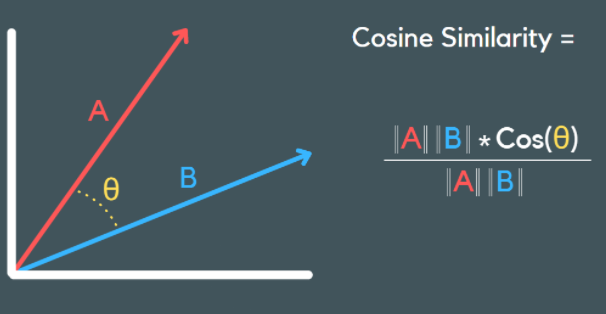

Additionnaly, we tunned the vectorizer parameters to see the differences of the results.
We did experiments with:

* Testing different ponderation schemes
* Testing different vocabulary sizes 
* Testing similarity mesuring with euclidean distance



**Finding most similar documents to the key-words**

In [21]:
#Setting the query
query = ["decision", "tree", "classification"]

In [22]:
#Function to get the cossine similarity between vectors
def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

In [23]:
def test_query_cossine_similarity(query, vectorizer):
    #getting the query and cleaning words that are not in the vocabulary
    query_string = " ".join(query)
    query_cleaned_string = clean_words(query_string)
    query = [query_cleaned_string]
    #turning the query into a vector with the same shape as the vectorizer 
    query_vec = vectorizer.transform(query)
    
    most_similars_doc = []
    
    #Comparing the query with every document in the dataset
    for index, row in data.iterrows():
        document_vec = vectorizer.transform([data['text_clean'].iloc[index]])
        value_similars = get_cosine_similarity(document_vec, query_vec)
        #Chosing the documents that have a cossine similarity higher than 0.45 with the query
        if (value_similars > 0.45):
            most_similars_doc.append({"index" : index, "document" :data['text_clean'].iloc[index], "cossine_similarity": value_similars})
        
    return most_similars_doc
    

In [24]:
#getting the most similars documents with the query
most_similars_doc = test_query_cossine_similarity(query, vectorizer)
most_similars_df = pd.DataFrame.from_dict(most_similars_doc, orient='columns')
most_similars_df.style.highlight_max(subset= ['cossine_similarity'] , color = 'green')

,index,document,cossine_similarity
0,2,classification datasets mining decision tree important induction research mining mainly classification prediction widely decision tree far shortcoming inclining choose attributes many values discussed decision tree improved version attributes divided groups apply selection measure groups gain good divide attributes values groups steps done get good classification misclassification ratio classify sets accurately efficiently,0.498961
1,991,mflexdt multi flexible fuzzy decision tree stream classification many real world applications instances arrive sequentially form streams processing poses challenges machine adhering line strategies extend flexible fuzzy decision tree flexdt multiple partitioning makes possible carry automatic line fuzzy classification aimed balance accuracy tree size stream mining objective classification predict true class incoming instances real terms evaluation accuracy tree depth significant factors influencing series experiments demonstrate produces optimal trees numeric nominal features variables,0.464134


**Comments:** `In the dataframe we can see the documents that had a cossine similarity bigger then 0.45 compared to the key words. We can see the main text and the results `

#### Testing with different ponderation scheams (TF-TFIDF-CountVectorizer)

In [25]:
vectorizers = [TfidfVectorizer(min_df=2), TfidfVectorizer(min_df=2, use_idf=False)]

results = pd.DataFrame(columns = ['index', 'document', 'cossine_similarity', 'vectorizer'])

#Chosing different vectorizers to do the text similarity from the search engine
for vectorizer in vectorizers:
    vectors = vectorizer.fit_transform(data['text_clean'])
    
    most_similars_doc = test_query_cossine_similarity(query, vectorizer)
    
    results = results.append(pd.json_normalize(most_similars_doc)) 
    results.reset_index(drop=True, inplace=True)
    
    for index, row in results.iterrows():
        if (pd.isnull(results['vectorizer'].iloc[index])):
            results.loc[index, 'vectorizer'] = vectorizer

In [26]:
results

,index,document,cossine_similarity,vectorizer
0,2,classification datasets mining decision tree i...,0.498961,TfidfVectorizer(min_df=2)
1,991,mflexdt multi flexible fuzzy decision tree str...,0.464134,TfidfVectorizer(min_df=2)
2,2,classification datasets mining decision tree i...,0.560316,"TfidfVectorizer(min_df=2, use_idf=False)"
3,991,mflexdt multi flexible fuzzy decision tree str...,0.500000,"TfidfVectorizer(min_df=2, use_idf=False)"
4,1678,decision forest twenty years research decision...,0.508475,"TfidfVectorizer(min_df=2, use_idf=False)"


**Comments:** `The simple count vector had a higher cossine similarity then TF-IDF, so we choose it to continue the search engine. `

#### Testing with different vocabulary sizes

In [27]:
vectorizers = [TfidfVectorizer(min_df=2,  max_features=10000, use_idf=False), \
               TfidfVectorizer(min_df=2, max_features=1000, use_idf=False),\
              TfidfVectorizer(min_df=2, max_features=500, use_idf=False)]

results = pd.DataFrame(columns = ['index', 'document', 'cossine_similarity', 'vectorizer'])
for vectorizer in vectorizers:
    vectors = vectorizer.fit_transform(data['text_clean'])
    
    most_similars_doc = test_query_cossine_similarity(query, vectorizer)
    
    results = results.append(pd.json_normalize(most_similars_doc)) 
    results.reset_index(inplace=True, drop=True)
    
    for index, row in results.iterrows():
        if (pd.isnull(results['vectorizer'].iloc[index])):
            results.loc[index, 'vectorizer'] = vectorizer


In [28]:
results

,index,document,cossine_similarity,vectorizer
0,2,classification datasets mining decision tree i...,0.560316,"TfidfVectorizer(max_features=10000, min_df=2, ..."
1,991,mflexdt multi flexible fuzzy decision tree str...,0.502331,"TfidfVectorizer(max_features=10000, min_df=2, ..."
2,1678,decision forest twenty years research decision...,0.508475,"TfidfVectorizer(max_features=10000, min_df=2, ..."
3,2,classification datasets mining decision tree i...,0.608164,"TfidfVectorizer(max_features=1000, min_df=2, u..."
4,991,mflexdt multi flexible fuzzy decision tree str...,0.563602,"TfidfVectorizer(max_features=1000, min_df=2, u..."
5,1678,decision forest twenty years research decision...,0.587137,"TfidfVectorizer(max_features=1000, min_df=2, u..."
6,4127,customer churn mobile markets comparison techn...,0.452911,"TfidfVectorizer(max_features=1000, min_df=2, u..."
7,8310,novel random forests application classificatio...,0.482451,"TfidfVectorizer(max_features=1000, min_df=2, u..."
8,9028,dominance rough group decisions objective supp...,0.488678,"TfidfVectorizer(max_features=1000, min_df=2, u..."
9,2,classification datasets mining decision tree i...,0.757937,"TfidfVectorizer(max_features=500, min_df=2, us..."


**Comments:** `We got a higher cossine similarity when the vocabulary size is limited to 500, because this way the data vocabulary doesn't have to many words that are rare or appear to often. `

#### Testing with the euclidean distance

In [29]:
#Function to get euclidean distance between vectors
def get_euclidean_distance(feature_vec_1, feature_vec_2):    
    return euclidean_distances(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

In [30]:
def test_query_euclidean_similarity(query, vectorizer):
    #getting the query and cleaning words that are not in the vocabulary
    query_string = " ".join(query)
    query_cleaned_string = clean_words(query_string)
    query = [query_cleaned_string]
    #turning the query into a vector with the same shape as the vectorizer 
    query_vec = vectorizer.transform(query)
    
    old_euclidean_distance = 100
    old_index = 0
    most_similars_doc = []
    for index, row in data.iterrows():
        document_vec = vectorizer.transform([data['text_clean'].iloc[index]])
        euclidean_distance = get_euclidean_distance(document_vec, query_vec)
        if (euclidean_distance < old_euclidean_distance):
            old_euclidean_distance = euclidean_distance
            old_index = index
    most_similars_doc.append({"index" : old_index, "document" :data['text_clean'].iloc[old_index], "euclidean_similarity": old_euclidean_distance})
    return most_similars_doc

In [31]:
most_similar_doc_euclidean = test_query_euclidean_similarity(query, vectorizer)

In [32]:
most_similar_doc_euclidean

[{'index': 2,
  'document': 'classification datasets mining decision tree important induction research mining mainly classification prediction widely decision tree far shortcoming inclining choose attributes many values discussed decision tree improved version attributes divided groups apply selection measure groups gain good divide attributes values groups steps done get good classification misclassification ratio classify sets accurately efficiently',
  'euclidean_similarity': 0.695792025019162}]

**Comments:** `Comparing texts by using the euclidean distance is hard because there is no reference values 
    and this distance is not always accurate in high dimensions.. `

**Results**
```
From the tests the best search engine that found documents similars to the query used a TF model with cossine similarity limiting the vocabulary size, taking out the less used words, the stop words and the most commom words. 
```